In [44]:
import numpy as np
import matplotlib.pylab as plt
import scipy.io
import pandas as pd
import numpy as np
import mne
from scipy import signal
import scipy.stats as stats

# 1. Data Loading

### About the dataset
- Dataset: Data set *‹self-paced 1s›*
- Source: https://www.bbci.de/competition/ii/berlin_desc.html
- Description: the goal is to predict the laterality of upcoming finger movements (left vs. right hand) 130 ms before keypress

### Format of the data
Given are 416 epochs of 500 ms length each ending 130 ms before a keypress. 316 epochs are labeled (0 for upcoming left hand movements and 1 for upcoming right hand movements), the remaining 100 epoches are unlabeled for competition purpose.

Data are provided in the original 1000 Hz sampling and in a version downsampled at 100 Hz (recommended). Files are provided in
- Matlab format (*.mat) containing variables: clab: electrode labels, x_train: training trials (time x channels x trials), y_train: corresponding labels (0: left, 1: right), x_test: test trials (time x channels x trials)
- zipped ASC II format (*.txt.zip). Each of those files contains a 2-D matrix where each row (line) contains the data of one trial, beginning with all samples of the first channel. Channels are in the following order: (F3, F1, Fz, F2, F4, FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, CP5, CP3, CP1, CPz, CP2, CP4, CP6, O1, O2). In the files containing training data the first entry in each row indicates the class (0: left, 1: right). In the 1000 Hz version trials consist of 500 samples per channel and in the 100 Hz version they consist of 50 samples.

### Technical data
The recording was made using a NeuroScan amplifier and a Ag/AgCl electrode cap from ECI. 28 EEG channels were measured at positions of the international 10/20-system (F, FC, C, and CP rows and O1, O2). Signals were recorded at 1000 Hz with a band-pass filter between 0.05 and 200 Hz.

### Requirements and Evaluation
Please provide your estimated class labels (0 or 1) for every trial of the test data and give a description of the used algorithm. The performance measure is the classification accuracy (correct classified trials divided by the total number of test trials).

### References
- Benjamin Blankertz, Gabriel Curio and Klaus-Robert Müller, Classifying Single Trial EEG: Towards Brain Computer Interfacing, In: T. G. Diettrich and S. Becker and Z. Ghahramani (eds.), Advances in Neural Inf. Proc. Systems 14 (NIPS 01), 2002.
- Data set provided by Fraunhofer-FIRST, Intelligent Data Analysis Group (Klaus-Robert Müller), and Freie Universität Berlin, Department of Neurology, Neurophysics Group (Gabriel Curio)

In [6]:
channel_names = ['F3', 'F1', 'Fz', 'F2', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'O1', 'O2']

In [7]:
# read EEG .mat file and load
mat_file_path = './data/sp1s_aa_1000Hz.mat'
mat_data = scipy.io.loadmat(mat_file_path)

In [8]:
# check the type of the data
print(type(mat_data))
print(mat_data.keys())

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'clab', 'x_train', 'y_train', 'x_test'])


In [9]:
# Access EEG train feature data from the loaded .mat file
eeg_train_X_data = mat_data['x_train']
eeg_train_X_data.shape # time * channel * trials

(500, 28, 316)

In [10]:
# Access EEG test data from the loaded .mat file
eeg_test_data = mat_data['x_test']
eeg_test_data.shape # time * channel * trials

(500, 28, 100)

In [11]:
# Access EEG train label data from the loaded .mat file
eeg_train_y_data = mat_data['y_train']
eeg_train_y_data.shape # time * channel * trials

(1, 316)

## 1-1. Raw Data Visualization

In [12]:
def plot_each_trial(data, trial_to_visualize=0):
    # Get dimensions of the data
    time, channels, trials = data.shape

    # Visualize the EEG signal of all channels for specific trial
    plt.figure(figsize=(16, 4))
    for channel in range(channels):
        plt.plot(data[:, channel, trial_to_visualize], label=f'{channel_names[channel]}')

    plt.title(f'EEG Data Visualization - Trial {trial_to_visualize + 1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', fontsize=7)
    plt.show()

In [13]:
def plot_each_channel(data, channel_to_visualize=0):
    # Get dimensions of the data
    time, channels, trials = data.shape

    # Visualize the EEG signal of all trials for certain channel
    plt.figure(figsize=(16, 4))
    for trial in range(trials):
        plt.plot(data[:, channel_to_visualize, trial])

    plt.title(f'EEG Data Visualization - Channel {channel_to_visualize + 1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()
    

In [14]:
def set_multiple_raw(data):
    n_channels = len(channel_names)

    # Get dimensions of the data
    time, channels, trials = eeg_train_X_data.shape

    raws = []
    for trial in range(trials):
        # Initialize an info structure
        sample_rate = 1000
        info = mne.create_info(
            ch_names=channel_names, 
            sfreq=sample_rate, 
            ch_types=['eeg']*n_channels)

        info.set_montage('standard_1020')

        # Create an MNE Raw object
        raw = mne.io.RawArray(np.transpose(eeg_train_X_data[:,:,trial]), info)
        raws.append(raw)
    return raws

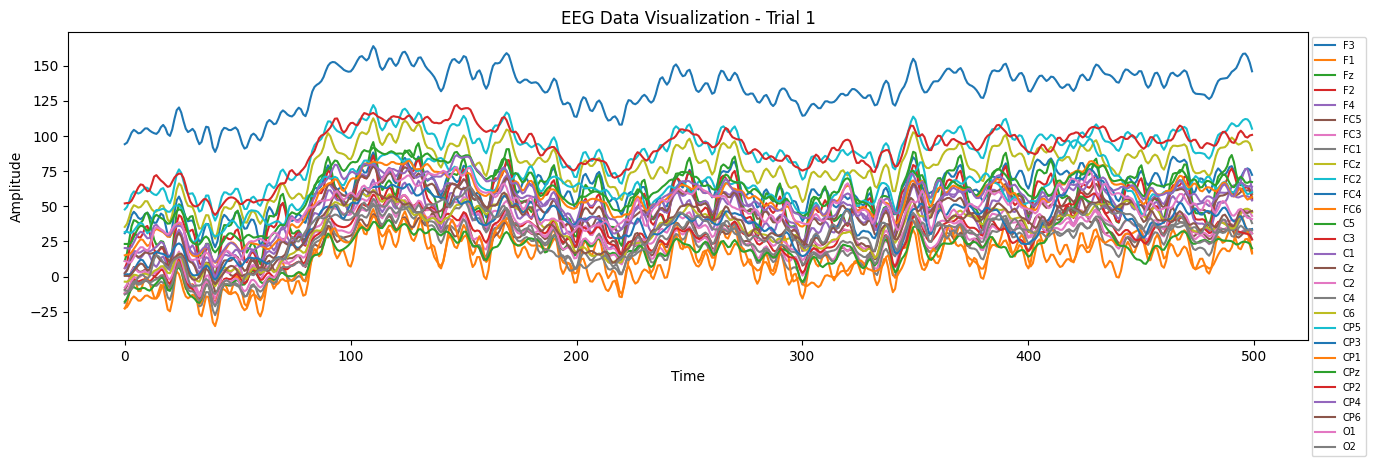

In [15]:
# Plot each channel for a specific trial
trial_to_visualize = 0  # Change this value based on the trial you want to visualize: 0 ~ 315

plot_each_trial(eeg_train_X_data, trial_to_visualize)

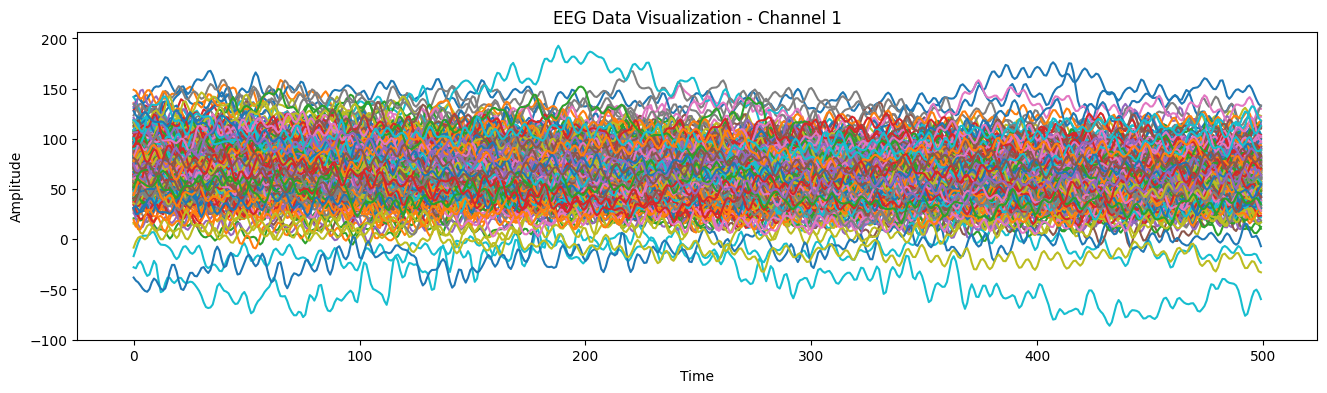

In [16]:
# Plot each trial for a specific channel
channel_to_visualize = 0  # Change this value based on the channel you want to visualize: 0 ~ 27

plot_each_channel(eeg_train_X_data, channel_to_visualize)

In [17]:
# Create raws of all trials
raws = set_multiple_raw(eeg_train_X_data)

Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.
Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.
Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.
Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.
Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.


Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.
Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.
Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.
Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.
Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.
Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.
Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.
Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.


Using matplotlib as 2D backend.


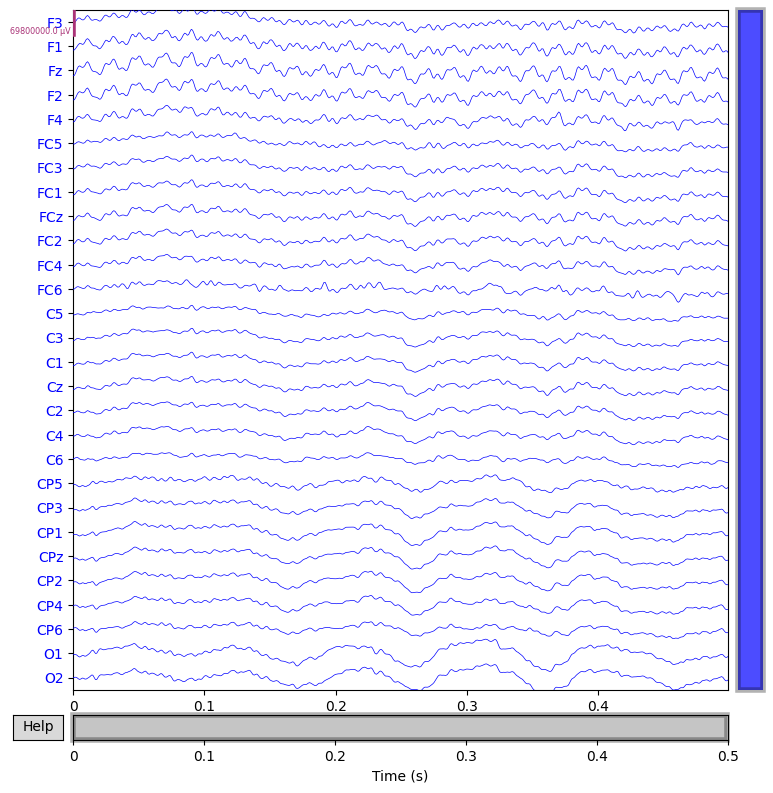

In [18]:
# Plot the EEG data using MNE
n_channels = len(channel_names)
trial_to_visualize = 10 # Change this value based on the trial you want to visualize: 0 ~ 315
fig = raws[trial_to_visualize].plot(n_channels=n_channels, title='EEG Data Visualization', scalings='auto', show=True, color='blue')


Effective window size : 0.500 (s)


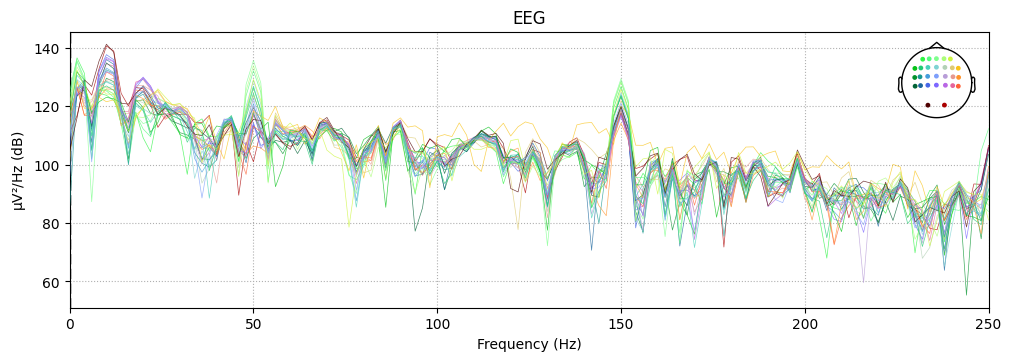

In [19]:
# Plot the power spectral density 
fig = raws[trial_to_visualize].compute_psd(fmax=250).plot(picks="data", exclude="bads", amplitude=False)

# 2. Data Preprocessing
### Contents
- Filtering
- Referencing
- Artifact Removal
- Epoching
- Baseline Correction
- Bad Channel Detection and Interpolation
- Downsampling
- Artifact Rejection
- etc.

In [20]:
trial_to_process = 0 # Change for sampling a specific trial: 0 ~ 315

# Create single trial from raws for sample preprocessing
raw = raws[trial_to_process].copy()
raw.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,31 points
Good channels,28 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,500.00 Hz


In [21]:
# Function for adding specific arrows on the plot data
def add_arrows(axes, pln_freqs):
    """Add some arrows at 50 Hz and its harmonics."""
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        for freq in pln_freqs:
            idx = np.searchsorted(freqs, freq)
            # get ymax of a small region around the freq. of interest
            y = psds[(idx - 4) : (idx + 5)].max()
            ax.arrow(
                x=freqs[idx],
                y=y + 18,
                dx=0,
                dy=-12,
                color="red",
                width=0.1,
                head_width=3,
                length_includes_head=True,
            )

In [22]:
# Function for comparison between the original signal and processed signal
def plot_comparison(raw, target_raw, type=None, fmax=50, process_name=None, arrow_points=None):
    for title, data in zip(["Original", process_name], [raw, target_raw]):
        if type == 'psd':       
            fig = data.compute_psd(fmax=fmax).plot(
                average=True, amplitude=False, picks="data", exclude="bads"
            )
            if arrow_points is not None:
                add_arrows(fig.axes[:2], arrow_points)

        elif type == 'raw':
            fig = data.plot(n_channels=n_channels, title='EEG Data Visualization', scalings='auto', show=True, color='blue')

        fig.suptitle("{}".format(title), size="x-large", weight="bold")

## 2-1. Filtering
- **Remove Baseline Drift:** Apply a high-pass filter to remove low-frequency drifts and baseline wander. Common high-pass filter frequencies are around 0.1 to 1 Hz.
- **Remove High-Frequency Noise:** Apply a low-pass filter to remove high-frequency noise. The cutoff frequency is often set between 30 and 50 Hz.

### *Powerline noise

Power line noise in EEG refers to unwanted electrical interference in the recorded EEG signal that is primarily associated with the frequency of the power line or mains electricity. In many regions, the power line frequency is 50 Hz or 60 Hz, depending on the electrical system used (e.g., 60 Hz in North America, 50 Hz in many parts of Europe and Asia). The interference caused by power line noise appears as a sinusoidal signal at the power line frequency and its harmonics (e.g., 100 Hz, 150 Hz, 200 Hz, etc.).

Key points about power line noise in EEG:

1. Source of Power Line Noise:
- Electromagnetic Interference (EMI): Electrical devices or cables in the environment can emit electromagnetic fields that couple with EEG electrodes, introducing power line noise.
- Improper Grounding: Issues with grounding or poorly grounded equipment can contribute to power line noise.
- Electrical Equipment in the Recording Room: Devices such as lighting, computers, or other electronic equipment in the recording environment can generate power line noise.
2. Frequency Characteristics:
- The main frequency of power line noise is typically the power line frequency itself (50 Hz or 60 Hz). Additionally, harmonics at multiples of the power line frequency may be present in the EEG signal.
3. Impact on EEG Data:
- Power line noise can obscure the underlying neural activity, making it more challenging to accurately analyze and interpret EEG data.
- It can introduce false peaks or distortions in the frequency spectrum, affecting the reliability of spectral analysis.
4. Prevention and Mitigation:
- Proper Shielding: Adequate shielding of cables and electrodes can help minimize the pickup of electromagnetic interference, including power line noise.
- Good Grounding Practices: Ensuring proper grounding of equipment and electrodes is essential to reduce the risk of power line noise.
- Faraday Cages: In some cases, recording setups may use Faraday cages or shielded rooms to minimize external interference.
5. Filtering and Preprocessing:
- Bandpass Filtering: Applying bandpass filters to the EEG data can help attenuate power line noise and its harmonics. A notch filter centered at the power line frequency is commonly used for this purpose.
- Artifact Removal Techniques: Independent Component Analysis (ICA) can be used to identify and remove components related to power line noise.



In [23]:
# Function for removing the power line noise
def remove_powerline_noise(raw, pln_freqs):
    # Convert mne raw data into numpy array for using scipy function
    raw_array = raw.copy().get_data()
    
    # Design and apply notch filters
    raw_notch = raw_array

    fs = raw.info["sfreq"] # Get sample frequency
    for freq in pln_freqs:
        q = 30.0  # Quality factor for the notch filter
        f0 = freq  # Normalize frequency to Nyquist frequency
        b, a = signal.iirnotch(f0, Q=q, fs=fs)
        raw_notch = signal.filtfilt(b, a, raw_notch)

    # Convert numpy array data into mne raw data for data analysis
    info = mne.create_info(ch_names=channel_names, sfreq=1000, ch_types='eeg')
    info.set_montage('standard_1020')
    raw_notch = mne.io.RawArray(raw_notch, info)

    return raw_notch


In [24]:
# Change to power line noise frequency: North Ameria or Korea(60Hz~), Europe(50Hz~)
pln_freqs = (50, 150, 250)

Effective window size : 0.500 (s)


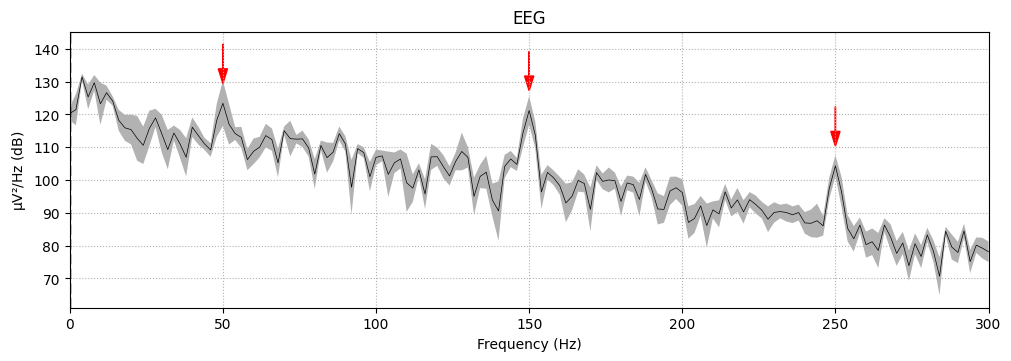

In [25]:
# Plot power spectral density for checking the powerline noise
fig = raw.compute_psd(fmax=300).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
# Set the arrows to see the powerline noise
add_arrows(fig.axes[:2], pln_freqs)

### Notch Filter
The notch filter is a combination of both low-pass and high-pass filters. It can attenuate signals within a specific range of frequencies. The range of frequencies that a band-stop filter attenuates is called the stopband.

Raw objects have a notch_filter method that takes in a specific frequency or a list of frequencies to attenuate the signal at. <code> raw.notch_filter(stop_freq) </code>

**However**
In this case, we use <code>scipy.signal.iirnotch</code> and <code>scipy.signal.filtfilt</code> since the original matlab data has been epoched. Notch filter on MNE doesn't work at short sample data (required transition bandwidth request large number of sample)

In [26]:
# Notch filter for removing power line noise
raw_notch = remove_powerline_noise(raw, pln_freqs)

Creating RawArray with float64 data, n_channels=28, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.499 secs
Ready.


Effective window size : 0.500 (s)


Effective window size : 0.500 (s)


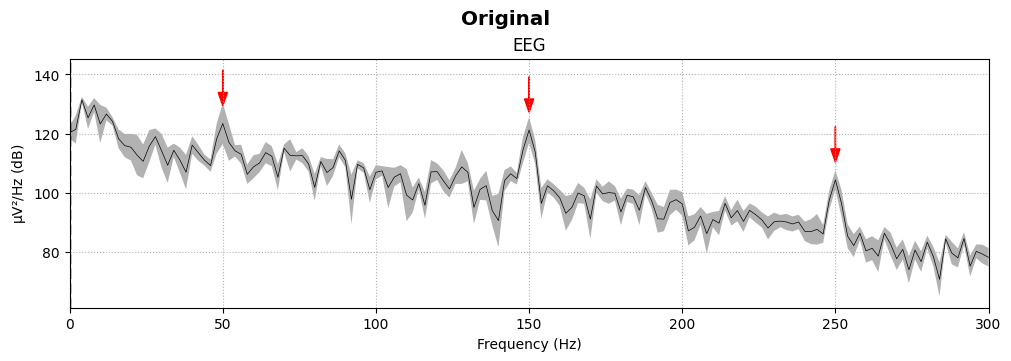

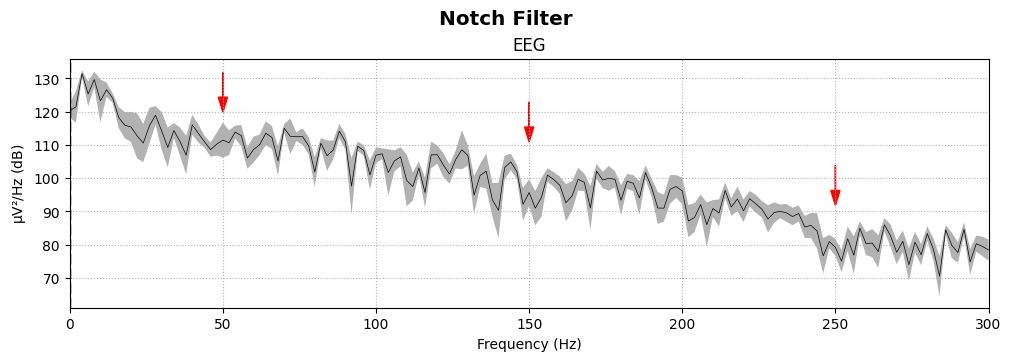

In [27]:
# Plot power spectral densities for checking the powerline noise and compare
plot_comparison(raw, raw_notch, type='psd', fmax=300, process_name='Notch Filter', arrow_points=pln_freqs)

### Band-pass filter
The process of EEG signal analysis used to use 0.01Hz ~ 50Hz. So, we try to filter between 0.01Hz and 50Hz in this case.

In [28]:
# Define the filter parameters
low_freq = 0.01  # Lower cutoff frequency in Hz
high_freq = 50.0  # Upper cutoff frequency in Hz

# Apply the bandpass filter
raw_band = raw_notch.copy().filter(l_freq=low_freq, h_freq=high_freq, picks='eeg')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 330001 samples (330.001 s)



/tmp/ipykernel_288930/4163577735.py:6: RuntimeWarning: filter_length (330001) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw_band = raw_notch.copy().filter(l_freq=low_freq, h_freq=high_freq, picks='eeg')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Effective window size : 0.500 (s)
Effective window size : 0.500 (s)


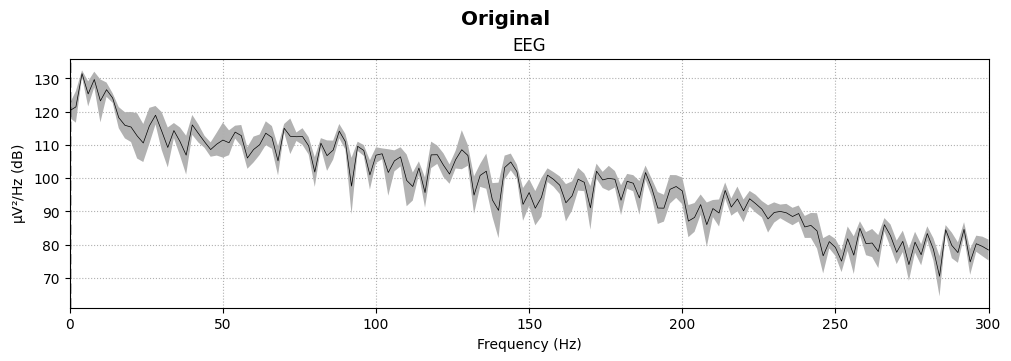

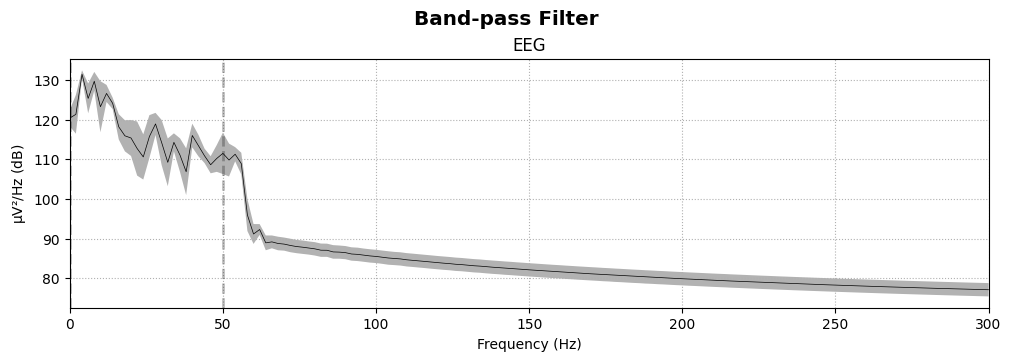

In [29]:
# Plot the power spectral density of band-pass filtered signal 
plot_comparison(raw_notch, raw_band, type='psd', fmax=300, process_name='Band-pass Filter')

## 2-2. Re-referencing
- Choose an appropriate reference for your EEG data. Common references include average reference, linked mastoids, or re-referencing to a specific electrode.

In [30]:
ref_ch = ["F2"] # Change reference channel as you want
# Use the average of all channels as reference
ref_avr = "average"

# Conduct CAR (Common Average Reference)
raw_ref = raw_band.copy().set_eeg_reference(ref_channels=ref_avr)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


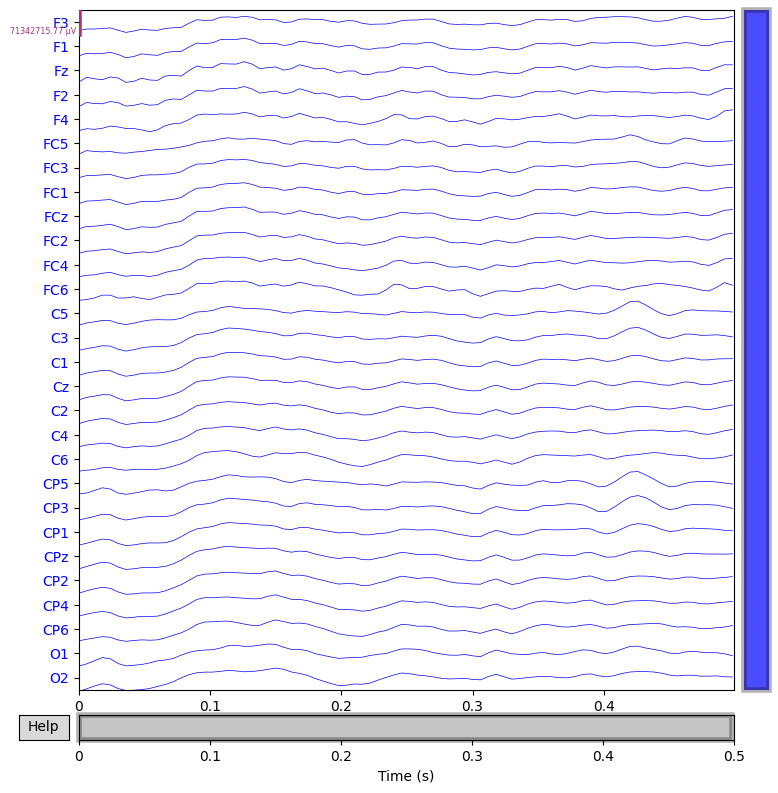

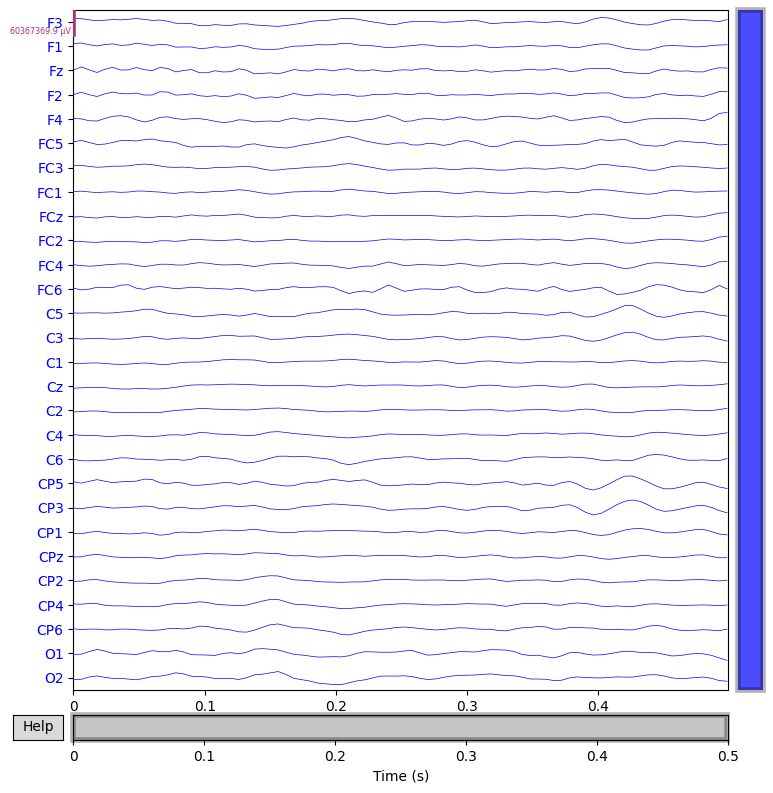

In [31]:
# Plot the re-referenced signal with average of all electrodes for compairison
plot_comparison(raw_band, raw_ref, type='raw', process_name='Rereferencing')

## 2-3. ICA (Independent Component Analysis)
Independent Component Analysis (ICA) is a dimensionality reduction approach. It is popular in blind source separation problems, where multivariate signals are decomposed into subcomponents while little-to-no information exists about the signal sources.

ICA can be done under the assumption that components are statistically independent of each other, and that no more than one subcomponent is Gaussian.

reference: https://betterprogramming.pub/independent-component-analysis-ica-and-automated-component-labeling-eeg-example-fccfe9b0ea64

In [32]:
# Create ICA object first
# ica_obj = mne.preprocessing.ICA(
#                     n_components=0.99,
#                     method='infomax',
#                     max_iter="auto",
#                     random_state=1,
#                     fit_params=dict(extended=True))

In [33]:
# ica_obj.fit(raw_ref)

In [34]:
# Plot the ICA scources
# fig = ica_obj.plot_sources(raw_ref)

In [35]:
# Plot the ICA components
# fig = ica_obj.plot_components()

In [36]:
# blinks
# fig = ica_obj.plot_overlay(raw_ref, exclude=[0], picks="eeg")

## 2-4. Resampling (Downsampling)

EEG recordings have a high temporal resolution, so they are often recorded at high sampling rates (eg. 1000 Hz or higher). Although this makes the recordings very precise, it also consumes more memory. In cases where highly precise timing is not needed, downsampling the EEG signal can help save a lot of computation time.

reference: https://reybahl.medium.com/eeg-signal-analysis-with-python-fdd8b4cbd306

In [37]:
# Down sample to a rate of 100Hz as recommended
resampling_sfreq = 100 # Change this rate of frequency for resampling
raw_resample = raw_ref.copy().resample(resampling_sfreq)

In [38]:
# Chenck the information of the resampled raw data
raw_resample.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,31 points
Good channels,28 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.01 Hz
Lowpass,50.00 Hz


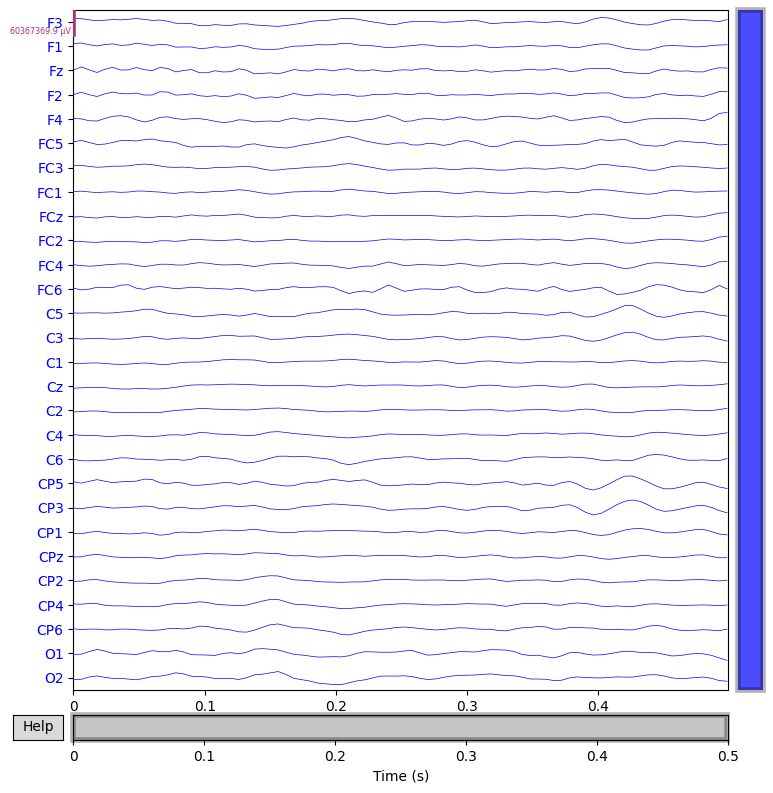

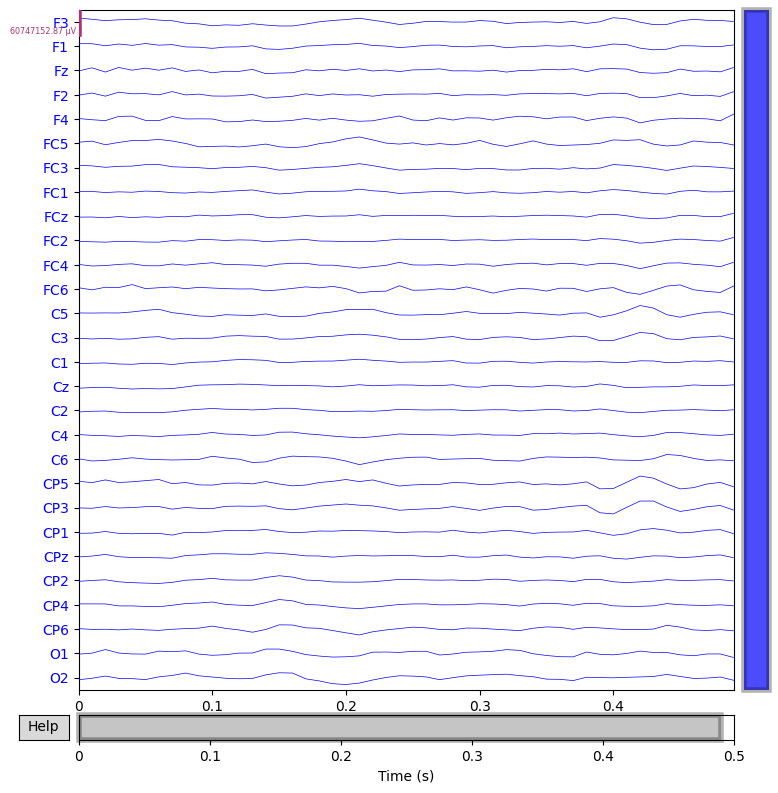

In [39]:
# Plot the raw comparison between previous data (rereferenced) and resampled data
plot_comparison(raw_ref, raw_resample, type='raw', process_name='Downsampling 100Hz')

Effective window size : 0.500 (s)
Effective window size : 0.500 (s)


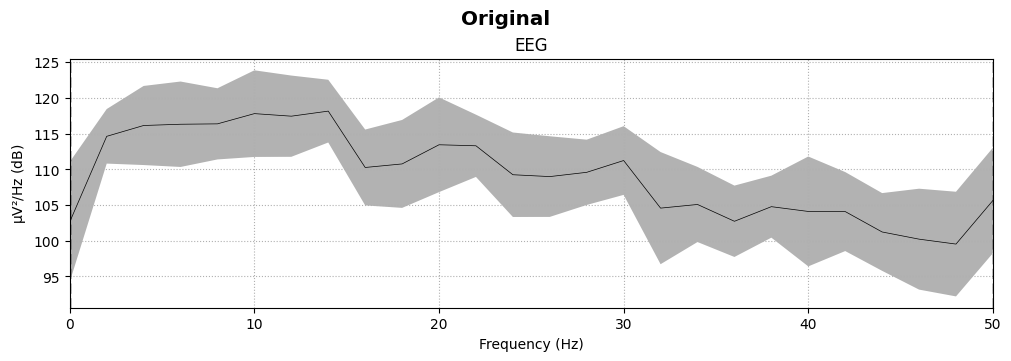

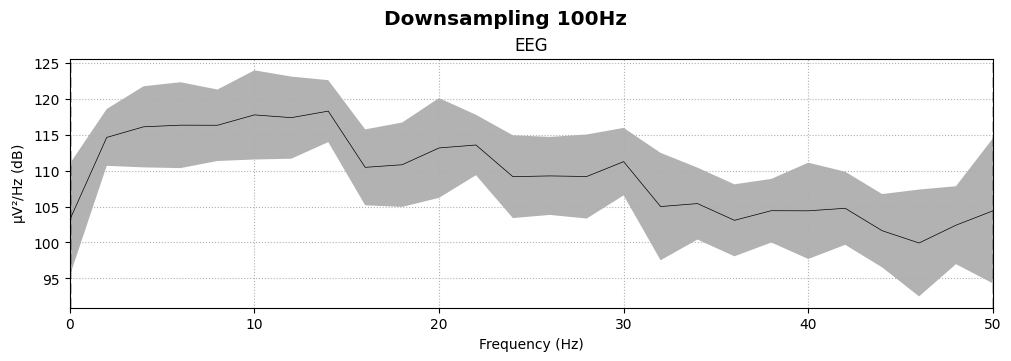

In [40]:
# Plot the power spectral density comparison between previous data (rereferenced) and resampled data
plot_comparison(raw_ref, raw_resample, type='psd', fmax=50, process_name='Downsampling 100Hz')

In [41]:
# Set the processed raw data
raw_processed = raw_resample.copy()
raw_processed.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,31 points
Good channels,28 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.01 Hz
Lowpass,50.00 Hz
